In [1]:
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random
import torch

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.backends import cudnn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.metrics import accuracy_score
from scipy.stats import sem
from sklearn.metrics import confusion_matrix

from collections import defaultdict

import albumentations as A

In [2]:
dataset_path = 'dataset/'
image_path = dataset_path+'faces/'

In [3]:
# добавляем рандом
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)

random_seed = 1120
seed_everything(random_seed)

In [4]:
# Преобразуем возрастные лейблы в 8 категорий
group_8class_age ={
    '0-2':['(0, 2)','2'],
    '4-6':['(4, 6)'],
    '8-13':['(8, 12)','13'],
    '15-20':['(15, 20)'],
    '25-32':['(25, 32)','(27, 32)','32','29'],
    '38-43':['(38, 43)','35', '36', '42','(38, 42)'],
    '48-53':['(48, 53)','42'],
    '60-':['(60, 100)']
}

# Алтернативное группирование, по 4ем категориям
group_4class_age={
'Личинус (0-6)':    ['(0, 2)', '2', '(4, 6)', '3'],
'Щегол (8-23)': ['(8, 12)', '(15, 20)', '(8, 23)', '23', '22', '13'],
'Бумер (25-32)':  ['(25, 32)', '(27, 32)', '32', '34', '29'],
'Старпёр 35+':  ['(48, 53)', '(60, 100)', '55','56','57', '58', '(38, 42)','(38, 43)', '(38, 48)', '35', '36', '46', '45', '42'],
}

In [5]:
# формируем лейблы на основе категорий
def map_age(group_to_age):
    age_to_group = {}
    for group in group_to_age.keys():
        age = group_to_age[group]
        for aa in age:
            age_to_group[aa] = group
    return age_to_group

# берем группировку из 4ех категорий
age_grouping = group_4class_age
age_to_label = map_age(age_grouping)

In [6]:
#считываем размеченный данные
test_fold = [pd.read_csv(f"{dataset_path}fold_0_data.txt",sep = "\t")]
test_fold.append(pd.read_csv(f"{dataset_path}fold_1_data.txt",sep = "\t"))
test_fold.append(pd.read_csv(f"{dataset_path}fold_2_data.txt",sep = "\t"))
test_fold.append(pd.read_csv(f"{dataset_path}fold_3_data.txt",sep = "\t"))
test_fold.append(pd.read_csv(f"{dataset_path}fold_4_data.txt",sep = "\t"))

all_age_group = pd.concat([test_fold[0],test_fold[1],test_fold[2], test_fold[3],test_fold[4]]).age.value_counts()
all_age_group = list(all_age_group.index)

In [7]:
drop_columns=['user_id', 'original_image', 'face_id', 'x', 'y', 'dx',
       'dy', 'tilt_ang', 'fiducial_yaw_angle', 'fiducial_score']

for fold, df in enumerate(test_fold):
    
    #полный путь до изображения
    df['image_path'] = image_path + df['user_id'] + '/coarse_tilt_aligned_face.' + \
        df['face_id'].astype('str') + '.' + df['original_image']
   
    #удаляем лишние колонки
    df.drop(drop_columns, axis=1, inplace=True)
    
    df.gender = df.gender.astype(str)
    df.age = df.age.astype(str)
    
    #удаляем строки с пустыми значениями
    df.drop(df[df.gender == 'u'].index, inplace=True)
    df.drop(df[df.gender == 'nan'].index, inplace=True)
    df.drop(df[df.age == 'None'].index, inplace=True)
    
    #лейбл возраста -> лейбл возрастной категории
    include_age = list(age_to_label.keys())
    exclude_age = list(set(all_age_group) - set(include_age))
    
    #удаляем если вдруг не попало ни в одну возрастную категорию
    for exc_age in exclude_age:
        df.drop(df.loc[df['age']==exc_age].index, inplace=True)
        
    #упорядочиваем индексы по возрасту
    df['age'] = df['age'].apply(lambda x: age_to_label[x])
    
    print(f'Fold {fold+1}  : {df.shape}\n')

Fold 1  : (3995, 3)

Fold 2  : (3597, 3)

Fold 3  : (3124, 3)

Fold 4  : (3291, 3)

Fold 5  : (3445, 3)



In [8]:
# 5 тренировочных фолдов, в виде разной последовтальности тестовых? кажется над переделать
train_fold = [pd.concat([test_fold[1],test_fold[2],test_fold[3],test_fold[4]],ignore_index=True)]
train_fold.append(pd.concat([test_fold[0],test_fold[2],test_fold[3],test_fold[4]],ignore_index=True))
train_fold.append(pd.concat([test_fold[0],test_fold[1],test_fold[3],test_fold[4]],ignore_index=True))
train_fold.append(pd.concat([test_fold[0],test_fold[1],test_fold[2],test_fold[4]],ignore_index=True))
train_fold.append(pd.concat([test_fold[0],test_fold[1],test_fold[2],test_fold[3]],ignore_index=True))

# датафрейм со всем фолдами
all_fold = pd.concat([test_fold[0],test_fold[1],test_fold[2],test_fold[3],test_fold[4]],ignore_index=True)

for k, fold in enumerate(train_fold):
    print(f'Fold {k+1}  : {fold.shape}')

Fold 1  : (13457, 3)
Fold 2  : (13855, 3)
Fold 3  : (14328, 3)
Fold 4  : (14161, 3)
Fold 5  : (14007, 3)


In [9]:
# приводим значения к числовым
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

# приводим значения к числовым
age_to_label_map = {
    'Личинус (0-6)' :0,
    'Щегол (8-23)' :1,
    'Бумер (25-32)' :2,
    'Старпёр 35+' :3
}

label_to_age_map = {value: key for key, value in age_to_label_map.items()}
label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

all_fold['age'].replace(age_to_label_map, inplace=True)
all_fold['gender'].replace(gender_to_label_map, inplace=True)

for i, fold in enumerate(train_fold):
    fold['age'].replace(age_to_label_map, inplace=True)
    fold['gender'].replace(gender_to_label_map, inplace=True)

for i, fold in enumerate(test_fold):
    fold['age'].replace(age_to_label_map, inplace=True)
    fold['gender'].replace(gender_to_label_map, inplace=True)

In [10]:
###
### Предобработка данных
###

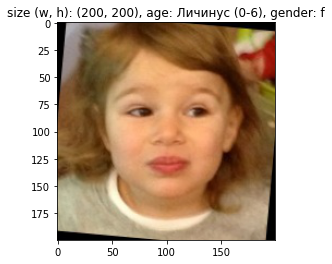

In [11]:
def show_image(img_filename, age, gender):
    img = Image.open(img_filename)
    plt.imshow(img)
    plt.title(f'size (w, h): {img.size}, age: {age}, gender: {gender}')
    plt.show()

idx = np.random.randint(all_fold.shape[0])
fname = all_fold['image_path'].iloc[idx]
age = label_to_age_map[all_fold['age'][idx]]
gender = label_to_gender_map[all_fold['gender'][idx]]
show_image(fname, age, gender)

In [12]:
###
### Классы моделей + аугментация (рамки)
###

In [13]:
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

In [14]:
class AgeDataset(Dataset):
    def __init__(self, path, image_files, labels_age, labels_gender, p_augment=0.5,  validation=False):
        self.path = path
        self.X = image_files
        self.y_age = labels_age
        self.y_gender = labels_gender
        self.resize = A.Resize(160, 160, always_apply=True)
        self.transform = trans
        
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.path + self.X[i])
        image = np.asarray(image)
        image = self.resize(image=image)['image']
        image = self.transform(image)
        label_age = self.y_age[i]
        label_gender = self.y_gender[i]
        
        return torch.tensor(image, dtype=torch.float), torch.tensor(label_age, dtype=torch.long)

In [15]:
class GenderDataset(Dataset):
    def __init__(self, path, image_files, labels_age, labels_gender, p_augment=0.5,  validation=False):
        self.path = path
        self.X = image_files
        self.y_age = labels_age
        self.y_gender = labels_gender
        self.resize = A.Resize(160, 160, always_apply=True)
        self.transform = trans
        
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.path + self.X[i])
        image = np.asarray(image)
        image = self.resize(image=image)['image']
        image = self.transform(image)
        label_age = self.y_age[i]
        label_gender = self.y_gender[i]
        
        return torch.tensor(image, dtype=torch.float), torch.tensor(label_gender, dtype=torch.long)

In [48]:
train_split={}
val_split={}

for fold in range(5):
    #create train-validation stratified split
    sss = StratifiedShuffleSplit(n_splits=10, random_state=random_seed)
    
    train_data = train_fold[fold]['image_path'].copy().reset_index(drop=True).to_list()
    train_gender_label = train_fold[fold]['gender'].copy().reset_index(drop=True).to_list()
    train_age_label = train_fold[fold]['age'].copy().reset_index(drop=True).to_list()
    train_idx, val_idx = list(sss.split(train_data, train_age_label))[0]
    
    print(f'Training data: {len(train_idx)}')
    print(f'Val. data: {len(val_idx)}')

Training data: 12111
Val. data: 1346
Training data: 12469
Val. data: 1386
Training data: 12895
Val. data: 1433
Training data: 12744
Val. data: 1417
Training data: 12606
Val. data: 1401


In [17]:
###
### Гиперпараметры (!!! говнокод. Переделать!!!)
###

In [18]:
print_sample=True
kfold = 5
batchsize = 64
lr_age = 3e-5
lr_gender= 2e-5
num_epochs = 10
p_augment = 0.0
mixup=False
augment=False


#General parameters
lrfinder=False
to_predict = 'gender'
device = torch.device("cpu")
num_age_classes = train_fold[0].age.value_counts().shape[0]
num_gender_classes = train_fold[0].gender.value_counts().shape[0]
num_age_classes, num_gender_classes

(4, 2)

In [19]:
#--- Что тут происходит??? ----

In [20]:
def mixup_data(x, y, alpha=1.0, use_cuda=False):

    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam


def mixup_criterion(y_a, y_b, lam):
    return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [21]:
###
### Обучение
###

In [22]:
#--- Классифиуируем только возраст  ----

In [24]:
print(num_gender_classes)

2


In [23]:
if to_predict == 'gender':
    all_accuracy_gender = []
    all_val_loss_gender = []
    all_stat_fold = []
    
    for fold in range(kfold):
        all_stat = defaultdict(list)
        
        # image paths
        train_data = train_fold[fold]['image_path'].copy().reset_index(drop=True).to_list()
        test_data  = test_fold[fold]['image_path'].copy().reset_index(drop=True).to_list()
    
        #get label
        train_age_label = train_fold[fold]['age'].copy().reset_index(drop=True).to_list()
        train_gender_label = train_fold[fold]['gender'].copy().reset_index(drop=True).to_list()
        test_age_label = test_fold[fold]['age'].copy().reset_index(drop=True).to_list()
        test_gender_label = test_fold[fold]['gender'].copy().reset_index(drop=True).to_list()
    
        #create train-validation stratified split
        sss = StratifiedShuffleSplit(n_splits=10, random_state=random_seed)
    
        #split based on age, more balanced for both age and gender
        train_idx, val_idx = list(sss.split(train_data, train_gender_label))[0]
    
        train_idx = list(train_idx)
        val_idx = list(val_idx)
    
        #create dataloader for gender
        train_dataset = GenderDataset('', 
                                          list(np.array(train_data)[train_idx]), 
                                          list(np.array(train_age_label)[train_idx]),
                                          list(np.array(train_gender_label)[train_idx]),
                                          p_augment = p_augment)
        val_dataset   = GenderDataset('', 
                                          list(np.array(train_data)[val_idx]), 
                                          list(np.array(train_age_label)[val_idx]),
                                          list(np.array(train_gender_label)[val_idx]),
                                          validation=True)
        test_dataset = GenderDataset('', 
                                  test_data, 
                                  test_age_label,
                                  test_gender_label, 
                                  validation=True)
    
    
        train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
        val_loader   = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
    
        val_gender_label = list(np.array(train_gender_label)[val_idx])
        val_age_label = list(np.array(train_age_label)[val_idx])
    
    
        model = InceptionResnetV1(
                        classify=True,
                        pretrained='vggface2',
                        num_classes=num_gender_classes)
        model = model.to(device)
    
        #optimizer
        optimizer = optim.AdamW(model.parameters(), lr = lr_gender)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [5,10])
    
        #loss
        criterion = nn.CrossEntropyLoss()
        
        if lrfinder ==True:
            !pip install torch-lr-finder
            from torch_lr_finder import LRFinder
            
            lr_finder = LRFinder(model, optimizer, criterion)
            lr_finder.range_test(train_loader, end_lr=2, num_iter=500)
            lr_finder.plot() # to inspect the loss-learning rate graph
            lr_finder.reset() # to reset the model and optimizer to their initial state
            
        best_acc_gender = 0
        best_val_loss_gender = 999
        print(f'Fold {fold+1}\n')
        for epoch in range(num_epochs):
            print(f'epoch: {epoch}\n')
            train_loss_gender = 0
            val_loss_gender = 0
        
            #Training
            model.train()
            print(f'trained: {epoch}\n')
            for batch in train_loader:
    
                # Load image batch
                batch_data, batch_gender_label = batch
                batch_data = batch_data.to(device)
                batch_gender_label = batch_gender_label.to(device)
                
                # Clear gradients
                optimizer.zero_grad()
            
                with torch.set_grad_enabled(True):
                    
                    if mixup == True:
                        # Mixup
                        inputs, targets_a, targets_b, lam = mixup_data(batch_data, 
                                batch_gender_label, alpha= 0.4)
                
                        # Forward pass
                        pred_gender = model(inputs)

                        # Loss
                        loss_func = mixup_criterion(targets_a, targets_b, lam)
                        loss_gender = loss_func(criterion, pred_gender)
                    else:
                        pred_gender = model(batch_data)
                        loss_gender = criterion(pred_gender, batch_gender_label)
            
                    train_loss_gender += loss_gender.detach().item()
                    loss_gender.backward()
                    optimizer.step()
            
            
            #Validation
            model.eval()
            all_pred_gender = torch.empty(0).to(device)
            for batch in val_loader:
            
                # Load image batch
                batch_data, batch_gender_label = batch
                batch_data = batch_data.to(device)
                batch_gender_label = batch_gender_label.to(device)
                
                with torch.set_grad_enabled(False):
                
                    pred_gender = model(batch_data)
                   
                    loss_gender = criterion(pred_gender, batch_gender_label)
            
                    val_loss_gender += loss_gender.detach().item()
                
                    all_pred_gender = torch.cat((all_pred_gender, 
                            nn.functional.softmax(pred_gender.detach(),dim=1)), 0)
                
        
            train_loss_gender /= len(train_loader)
            val_loss_gender /= len(val_loader)
        
            all_pred_gender = all_pred_gender.cpu().numpy()
            pred_label_gender = list(np.argmax(all_pred_gender,axis=1))
       
        
            acc_gender = accuracy_score(val_gender_label, pred_label_gender)
 
            if val_loss_gender < best_val_loss_gender:
                best_acc_gender=acc_gender
                best_val_loss_gender=val_loss_gender
                torch.save(model.state_dict(), f'model{fold}.pth')
            
            all_stat['train_loss'].append(train_loss_gender)
            all_stat['val_loss'].append(val_loss_gender)
            all_stat['val_acc'].append(acc_gender)
            
            print(f'Epoch {epoch} | train loss: {train_loss_gender} | val loss: {val_loss_gender} | accuracy: {round(acc_gender*100, 2)}%')
            scheduler.step()
        
        #INFERENCE
        with torch.no_grad():
            model.load_state_dict(torch.load(f'model{fold}.pth'))
            model.eval()
            test_pred_gender = torch.empty(0).to(device)
            for batch in test_loader:
            
                # Load image batch
                batch_data, batch_gender_label = batch
                batch_data = batch_data.to(device)
                batch_gender_label = batch_gender_label.to(device)
            
                with torch.set_grad_enabled(False):
                
                    pred_gender = model(batch_data)
               
                    test_pred_gender = torch.cat((test_pred_gender, 
                            nn.functional.softmax(pred_gender.detach(),dim=1)), 0)
                
        
       
        
            test_pred_gender = test_pred_gender.cpu().numpy()
            pred_label_gender = list(np.argmax(test_pred_gender,axis=1))
        
            acc_gender = accuracy_score(test_gender_label, pred_label_gender)
            all_stat['test_acc'].append(acc_gender)
            all_stat['conf'].append(confusion_matrix(test_gender_label, pred_label_gender, labels=list(range(num_gender_classes))))
            all_stat['conf_norm'].append(confusion_matrix(test_gender_label, pred_label_gender,normalize='true', labels=list(range(num_gender_classes))))
            all_stat['test_pred'].append(pred_label_gender)
            all_stat['test_target'].append(test_gender_label)
        all_accuracy_gender.append(acc_gender)
        all_val_loss_gender.append(best_val_loss_gender)
        print(f'TEST ACCURACY: {round(acc_gender*100,2)}% | Val. Accuracy: {round(best_acc_gender*100,2)}% | Val. Loss.: {best_val_loss_gender}\n')
        
        all_stat_fold.append(all_stat)

    all_accuracy_gender = np.array(all_accuracy_gender)
    all_val_loss_gender = np.array(all_val_loss_gender)

    mean_accuracy_gender = round(all_accuracy_gender.mean()*100, 2)
    sem_accuracy_gender = round(sem(all_accuracy_gender)*100, 2)

    print(f'\nOverall Accuracy: {mean_accuracy_gender} p/m {sem_accuracy_gender}')

    with open('gender_results_mixup.pkl','wb') as fr:
        pickle.dump(all_stat_fold, fr)

Fold 1

epoch: 0

trained: 0



<ipython-input-15-c5aa7d387409>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float), torch.tensor(label_gender, dtype=torch.long)


Epoch 0 | train loss: 0.18190792947027243 | val loss: 0.07678648994558236 | accuracy: 97.55%


<ipython-input-15-c5aa7d387409>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float), torch.tensor(label_gender, dtype=torch.long)


TEST ACCURACY: 94.84% | Val. Accuracy: 97.55% | Val. Loss.: 0.07678648994558236

Fold 2

epoch: 0

trained: 0



<ipython-input-15-c5aa7d387409>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float), torch.tensor(label_gender, dtype=torch.long)


KeyboardInterrupt: 

In [58]:
test_pred_gender = torch.empty(0).to(device)
for batch in test_loader:
    batch_data, batch_label = batch
    print(len(batch_data[0]),len(batch_data[0][0]),len(batch_data[0][0][0]))
    pred_gender = model(batch_data)
               
    test_pred_gender = torch.cat((test_pred_gender, 
                            nn.functional.softmax(pred_gender.detach(),dim=1)), 0)
    
    test_pred_gender = test_pred_gender.cpu().numpy()
    print(test_pred_gender)

<ipython-input-15-c5aa7d387409>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float), torch.tensor(label_gender, dtype=torch.long)


3 160 160
[[9.5876116e-01 4.1238792e-02]
 [1.8236328e-02 9.8176366e-01]
 [9.2943913e-01 7.0560843e-02]
 [3.6539248e-01 6.3460755e-01]
 [7.9720098e-01 2.0279896e-01]
 [4.6609515e-01 5.3390491e-01]
 [9.4280070e-01 5.7199296e-02]
 [7.2141963e-01 2.7858037e-01]
 [7.7613461e-01 2.2386536e-01]
 [1.1871895e-03 9.9881279e-01]
 [9.6220696e-01 3.7793010e-02]
 [8.1309229e-01 1.8690769e-01]
 [5.0168973e-01 4.9831021e-01]
 [4.8304936e-01 5.1695061e-01]
 [7.0257729e-01 2.9742265e-01]
 [9.7749889e-01 2.2501113e-02]
 [2.9968497e-01 7.0031500e-01]
 [8.7733710e-01 1.2266290e-01]
 [8.1809806e-03 9.9181902e-01]
 [4.8197713e-03 9.9518025e-01]
 [8.3228876e-04 9.9916768e-01]
 [5.9997465e-02 9.4000256e-01]
 [9.7623062e-01 2.3769410e-02]
 [3.7305027e-01 6.2694967e-01]
 [4.9583393e-01 5.0416613e-01]
 [9.0613741e-01 9.3862593e-02]
 [1.3491762e-01 8.6508238e-01]
 [8.4163463e-01 1.5836534e-01]
 [9.8471975e-01 1.5280194e-02]
 [9.7106940e-01 2.8930627e-02]
 [9.6003884e-01 3.9961219e-02]
 [9.5296872e-01 4.7031287e-02

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [57]:
print(test_age_label)

[3, 3, 0, 0, 3, 0, 1, 0, 1, 1, 0, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 0, 1, 3, 1, 1, 3, 1, 1, 0, 3, 1, 0, 1, 1, 0, 0, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 0, 1, 1, 3, 3, 1, 1, 0, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 0, 3, 1, 3, 1, 3, 3, 3, 3, 0, 0, 1, 3, 1, 1, 3, 1, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 0, 0, 1, 3, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 3, 1, 1, 3, 3, 1, 1, 0, 3, 1, 1, 1, 1, 1, 0, 1, 1, 0, 3, 1, 1, 1, 1, 0, 1, 0, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 0, 3, 1, 1, 1, 0, 1, 1, 0, 1, 3, 0, 3, 1, 0, 1, 3, 3, 3, 0, 3, 1, 3, 1, 0, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 0, 0, 1, 3, 0, 3, 3, 0, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 0, 0, 1, 3, 3, 0, 0, 0, 1, 3, 3, 1, 1, 0, 3, 1, 1, 3, 0, 3, 1, 3, 0, 3, 3, 0, 1, 3, 0, 3, 3, 0, 1, 1, 1, 1, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 0, 1, 1, 3, 0, 3, 0, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 0, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 0, 1, 1, 0, 1, 1, 3, 

In [50]:
test_fold[fold]['image_path'][0]

'dataset/faces/115321157@N03/coarse_tilt_aligned_face.1744.12111738395_a7f715aa4e_o.jpg'